**Dopasowanie modelu do danych** metodą najmniejszych kwadratów (ang. *least-squares method*)

Import danych z internetu działa na takiej samej zasadzie, jak na poprzednim laboratorium. Za pomocą web-scrapingu sciągam tabelę najludniejszych miast Europy z Wikipedii.

In [26]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

URL = "https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df = pd.read_html(str(tab))[0]
df =df.loc[:, 'City':'Officialpopulation':]
df.replace(to_replace={'[[a]]':"",'[[b]]':""}, regex=True,inplace=True)
df.replace(to_replace='[[,]', value="", regex=True,inplace=True)
for i in range(len(df['Officialpopulation'])):
    df['Officialpopulation'][i] = float("{:.2f}".format(int(df['Officialpopulation'][i])/1000000))
df = df[:11]
df

,City,Country,Officialpopulation
0,Istanbul,Turkey,15.84
1,Moscow,Russia,12.63
2,London,United Kingdom,9.0
3,Saint Petersburg,Russia,5.38
4,Berlin,Germany,3.66
5,Madrid,Spain,3.31
6,Kyiv,Ukraine,2.92
7,Rome,Italy,2.84
8,Bucharest,Romania,2.16
9,Paris,France,2.14


Moim celem będzie sprawdzenie, czy zaludnienie danego kraju wpływa na liczbę mieszkańców w największych miastach. Aby to osiągnąć, ściągam z Wikipedii dodatkowe dane dotyczące ludności w europejskich państwach i łączę ję z istniejącym już data frame'em.

In [27]:
import re
URL = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df1 = pd.read_html(str(tab))[0]
pop = dict(zip(df1["Country / Dependency"],df1["Population"]))
i=0
for country in df["Country"]:
    df.at[i,"Countrypopulation"] = float("{:.2f}".format(pop.get(country)/1000000))
    i+=1
df 

,City,Country,Officialpopulation,Countrypopulation
0,Istanbul,Turkey,15.84,84.68
1,Moscow,Russia,12.63,145.48
2,London,United Kingdom,9.0,67.08
3,Saint Petersburg,Russia,5.38,145.48
4,Berlin,Germany,3.66,83.22
5,Madrid,Spain,3.31,47.33
6,Kyiv,Ukraine,2.92,41.13
7,Rome,Italy,2.84,58.95
8,Bucharest,Romania,2.16,19.19
9,Paris,France,2.14,67.83


Celem ćwiczenia jest utworzenie modelu, muszę zatem podzielić dane na dwa zbiory. 
Zbiór X zawiera wartości Populacji kraju
Zbiór Y zawiera wartości Ludności miasta

In [28]:
X = df['Countrypopulation'].values
Y = df['Officialpopulation'].values

print('Ludność kraju: %s' % X)
print('Liczba mieszkańców miasta: %s' % Y)

Ludność kraju: [ 84.68 145.48  67.08 145.48  83.22  47.33  41.13  58.95  19.19  67.83
   9.35]
Liczba mieszkańców miasta: [15.84 12.63 9.0 5.38 3.66 3.31 2.92 2.84 2.16 2.14 2.01]


Za pomocą poniższego kodu, zaprezentuje rozkład danych X oraz Y, na wykresie

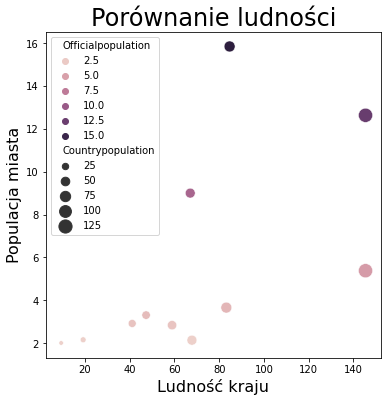

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.scatterplot(
    x = 'Countrypopulation',
    y = 'Officialpopulation',
    data = df,
    hue = 'Officialpopulation',
    size = 'Countrypopulation',
    sizes = (20, 200),
    legend = 'brief'
)
plt.xlabel("Ludność kraju", size=16)
plt.ylabel("Populacja miasta", size=16)
plt.title("Porównanie ludności", size=24)
plt.show()

Za pomocą metody analitycznej przedstawię model liniowy dla powyższych danych

y = 0.060867x + 1.3672


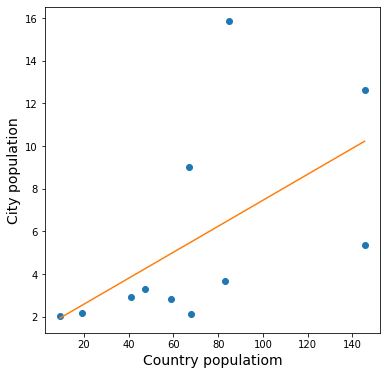

In [30]:
import numpy as np
def model(parametry, x):
  a, b = parametry
  return a*x + b

A = np.vstack([X, np.ones(X.shape[0])]).T
theta = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), Y)
#  w tym miejscu wprowadzasz wzory analityczne
a_est = theta[0]
b_est = theta[1]

print(f'y = {a_est:0.5}x + {b_est:0.5}')

# utwórz wartości x dla całego zakresu zmienności na osi x
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
# "odpytaj" model dla zakresu osi x objętego pomiarami
Y_pred = model(parametry=[a_est, b_est], x=X_test)

plt.figure(figsize=(6,6))
plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('Country populatiom', fontsize=14)
plt.ylabel('City population', fontsize=14)
plt.show()

Poniżej reprezentacja modelu liniowego z biblioteki sklearn

y=  0.06087x + 1.36721


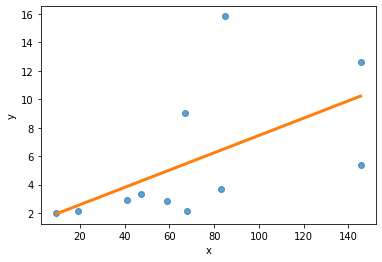

In [31]:
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X.reshape(-1,1),Y)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))

print(f'y =  {float(np.round(model_lin.coef_,5))}x + {np.round(model_lin.intercept_,5)}')


plt.scatter(X,Y, alpha=0.7)
plt.plot(X_test, Y_pred, color='tab:orange', linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Otrzymane wyniki są podobne, różni się głównie nachylenie linii. Ostatnim modelem, który zaprezentuję, będzie model wielomianowy

Parametry modelu liniowego: [0.05336], 0.94719
Błąd średniokwadratowy modelu liniowego: 35.9

Parametry modelu GLM: [0.        0.0264853 0.0001568], 1.77796
Błąd średniokwadratowy modelu GLM: 38.1



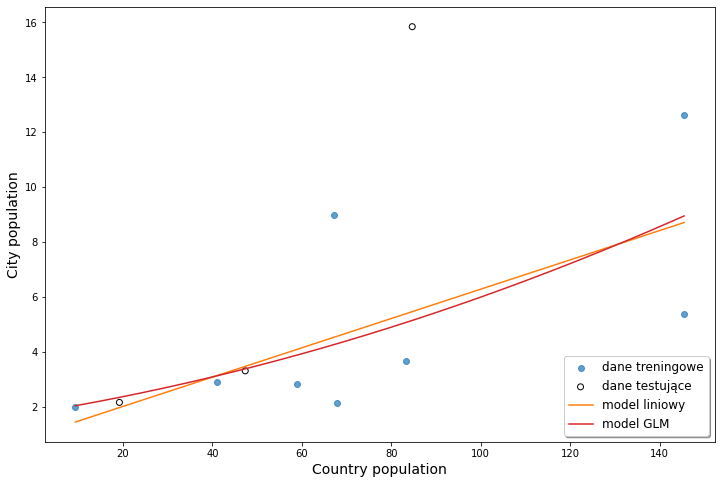

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# =========  Model liniowy =========
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X_train.reshape(-1,1),
              Y_train)
print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

# ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
from sklearn.preprocessing import PolynomialFeatures
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)),
              Y_train)
print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,7)}, {np.round(model_GLM.intercept_,5)}')
MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

# Predykcje wszystkich modeli dla całego zakreso osi X
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

# Wizualizacja
plt.figure(figsize=(12,8))
plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
plt.xlabel('Country population', fontsize=14)
plt.ylabel('City population', fontsize=14)
plt.legend(fontsize=12, shadow=True, loc='lower right')
plt.show()

Aby zbudować i przećwiczyć model muszę stworzyć dodatkowe zbiory. Zbiory X i Y dzielę na trenujące i testowe. 

W poniższym przykładzie przeprowadziłem obserwacje dla stosunku danych do trenowania i danych do testowania 30/70

Parametry modelu liniowego: [0.08105], -0.42222
Błąd średniokwadratowy modelu liniowego: 18.8

Parametry modelu GLM: [ 0.        -0.073109   0.0009761], 2.60824
Błąd średniokwadratowy modelu GLM: 32.9



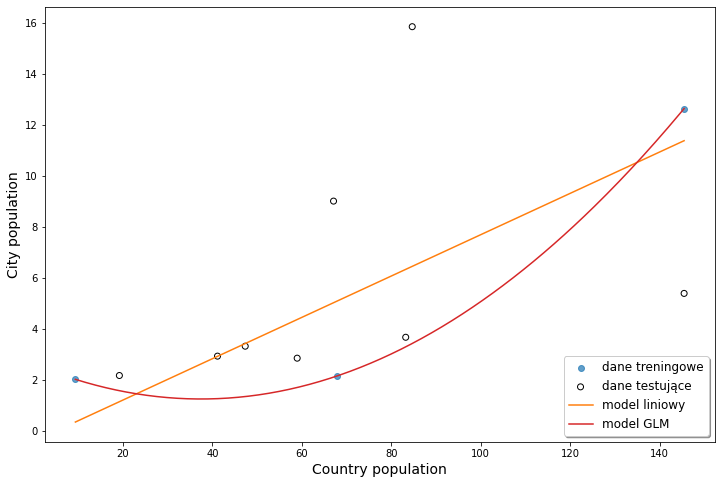

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3,test_size=0.7)

# =========  Model liniowy =========
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X_train.reshape(-1,1),
              Y_train)
print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

# ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
from sklearn.preprocessing import PolynomialFeatures
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)),
              Y_train)
print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,7)}, {np.round(model_GLM.intercept_,5)}')
MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

# Predykcje wszystkich modeli dla całego zakreso osi X
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

# Wizualizacja
plt.figure(figsize=(12,8))
plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
plt.xlabel('Country population', fontsize=14)
plt.ylabel('City population', fontsize=14)
plt.legend(fontsize=12, shadow=True, loc='lower right')
plt.show()

A następnie trenowanie 20%, testowanie 80%

Parametry modelu liniowego: [0.0629], 0.33279
Błąd średniokwadratowy modelu liniowego: 18.1

Parametry modelu GLM: [-0.00e+00  8.00e-06  7.11e-04], 1.71688
Błąd średniokwadratowy modelu GLM: 29.3



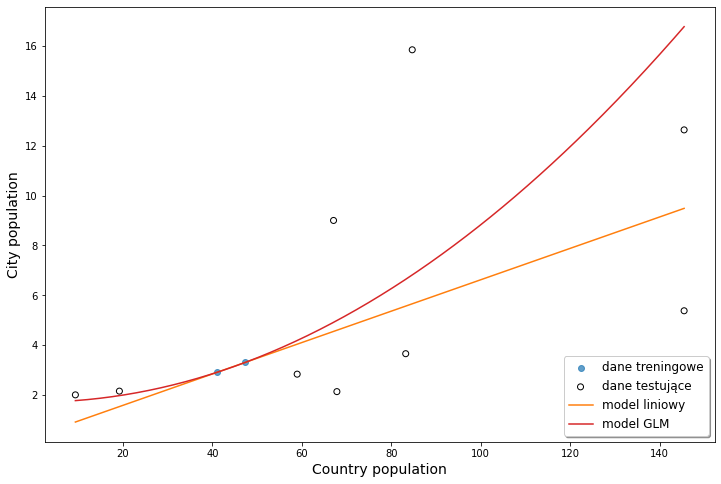

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2,test_size=0.8)

# =========  Model liniowy =========
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X_train.reshape(-1,1),
              Y_train)
print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

# ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
from sklearn.preprocessing import PolynomialFeatures
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)),
              Y_train)
print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,7)}, {np.round(model_GLM.intercept_,5)}')
MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

# Predykcje wszystkich modeli dla całego zakreso osi X
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

# Wizualizacja
plt.figure(figsize=(12,8))
plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
plt.xlabel('Country population', fontsize=14)
plt.ylabel('City population', fontsize=14)
plt.legend(fontsize=12, shadow=True, loc='lower right')
plt.show()